<div style='background-size:30%; background-position: 100% 100%; background-repeat:no-repeat; background-image:url("https://www.mn.uio.no/hylleraas/english/about/internal/graphical-profile/visual-profile/hylleraas-background-3.png"); height: 250px; position: relative; max-width: 100%; display: flex; flex-wrap:wrap;'>
    <div style='width:60%; min-width:130px; flex-grow:1; flex-shrink:0; flex-basis:60%'><h1 style="font-size:30pt; line-height: 1.25em;">&nbsp;<p>Generating potential energy surfaces with the <span style="font-size:30pt; color:#2b38ff">Hylleraas Software Platform</span></h1></div> 
    <div style="width:15%; flex-grow:1; flex-shrink:0; flex-basis:15%"></div>
    <div style='background-size:75%; background-position: 50% 0%; background-repeat:no-repeat; background-image:url("https://www.mn.uio.no/hylleraas/english/about/internal/graphical-profile/visual-profile/hylleraas-%E2%80%93-logo-%E2%80%93-screen-%E2%80%93-rgb.png"); width:25%; min-width:150px; flex-grow:1; flex-shrink:0; flex-basis:25%'></div>
</div>
<!--<div style='background-size:30%; background-position: 100% 100%; background-repeat:no-repeat; background-image:url("https://www.mn.uio.no/hylleraas/english/about/internal/graphical-profile/visual-profile/hylleraas-background-3.png"); height: 200px; position: relative; max-width: 100%; display: flex; flex-wrap:wrap;'>
    <div style='width:60%; min-width:130px; flex-grow:1; flex-shrink:0; flex-basis:50%'><h1 style="font-size:30pt; line-height: 1.25em;">Introduction to the Hylleraas Software Platform <code><span style="color:#2b38ff">Molecule</span></code> class</h1></div> 
</div>
-->

Using the unsubstituted biphenyl we created in the [molecule class introduction](https://www.this/link/is/a/placeholder.com), we can compute a simple <span style="font-weight:bold;color:#2b38ff">potential energy surface (PES)</span> by varying the carbon&ndash;carbon bond length and dihedral angle. Note that although the true <span style="font-weight:bold;color:#2b38ff">PES</span> is at least 60-dimensional, this simplified two-dimensional case serves to illustrate the concept of <span style="font-weight:bold;color:#2b38ff">PES</span> calculations.

In [1]:
import hylleraas as hsp
import scipy


def generate_biphenyl(bond_length: float, dihedral_angle: float) -> hsp.Molecule:
    """Generate a biphenyl system with specified carbon–carbon bond length 
    and dihedral angle.
    
    Parameters
    ----------
    bond_length : float
        Specified bond length in Å
    dihedral_angle : float
        Specified carbon–carbon dihedral angle in degrees
    
    Returns
    -------
    hylleraas.Molecule
        A Molecule object representing the biphenyl
    
    """
    if not bond_length > 0.0:
        raise ValueError(
            "Requested bond angle must be strictly positive, not {bond_angle}"
        )
    R: np.ndarray = scipy.spatial.transform.Rotation.from_euler(
        "y", [dihedral_angle], degrees=True
    ).as_matrix()
    benzene: hsp.Molecule = hsp.Molecule("benzene.xyz")
    benzene_2: hsp.Molecule = hsp.Molecule(benzene)
    benzene_2 = benzene_2.rotate(R)
    
    # The carbon atoms along the y-axis are located at ± 1.3948 Å
    benzene_2 = benzene_2.translate([0.0, 2 * 1.3948 + bond_length, 0.0])
    biphenyl: hsp.Molecule = benzene + benzene_2
    return biphenyl - biphenyl[9, 20]


biphenyl = generate_biphenyl(bond_length=1.5, dihedral_angle=44.0)
hsp.view(biphenyl, style="stick")
None

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

By varying the `bond_length` and `dihedral_angle` input to `generate_biphenyl(...)`, we can generate a matrix of configurations.

In [2]:
import numpy as np
import py3Dmol
import ipywidgets


def interactive_draw(
    bond_length: float, 
    dihedral_angle: float,
    style: str,
    view_object: py3Dmol.view,
) -> None:
    molecule: hsp.Molecule = generate_biphenyl(bond_length, dihedral_angle)
    molecule = molecule.rotate(np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]))
    view_object = hsp.view(
        molecule, 
        view_object=view_object, 
        style=style,
        show=False, 
        return_view=False,
    )
    return None


adjust_font = lambda s: f"""<span style="font-size:15pt">{s}</span>"""
bond_length_slider = ipywidgets.FloatSlider(
    value=1.5, min=0.75, max=3.0, step=0.01, description=adjust_font("Bond length"),
    style={'description_width': 'initial'}, layout=ipywidgets.Layout(width='75%'),
)
dihedral_angle_slider = ipywidgets.FloatSlider(
    value=0.0, min=0.0, max=180.0, step=0.1, description=adjust_font("Dihedral angle"),
    style={'description_width': 'initial'}, layout=ipywidgets.Layout(width='75%'),
)
style_button = ipywidgets.ToggleButtons(
    options=['ballstick', 'stick', 'sphere'], description=adjust_font("Style"),
    disabled=False, button_style='', layout=ipywidgets.Layout(width='75%'),
)

view_object: py3Dmol.view = hsp.view(generate_biphenyl(1.5, 0.0), show=False)
ipywidgets.interact(
    interactive_draw, 
    bond_length=bond_length_slider,
    dihedral_angle=dihedral_angle_slider,
    style=style_button,
    view_object=ipywidgets.fixed(view_object),
)
None

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

interactive(children=(FloatSlider(value=1.5, description='<span style="font-size:15pt">Bond length</span>', la…

Using this machinery, we can iterate over bond lengths and dihedral angles and compute the energy for each configuration, therby calculating a rough estimate of the <span style="font-weight:bold;color:#2b38ff">potential energy surface (PES)</span>.

In [69]:
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
import shutil
import pathlib


def biphenyl_energy(bond_length: float, dihedral_angle: float):
    """Calculate the xTB energy of the specified biphenyl 
    configuration.
    
    Parameters
    ----------
    bond_length : float
        Specified bond length in Å
    dihedral_angle : float
        Specified carbon–carbon dihedral angle in degrees
    
    Returns
    -------
    float
        Total xTB energy

    """
    molecule: hsp.Molecule = generate_biphenyl(bond_length, dihedral_angle)
    method: hsp.Method = hsp.Method(program="xtb")
    return method.get_energy(molecule)

n: int = 32
bond_lenghts: np.ndarray = np.linspace(1.4, 1.6, n)
dihedral_angles: np.ndarray = np.linspace(0.0, 180.0, n)
X, Y = np.meshgrid(bond_lenghts, dihedral_angles, indexing='ij')
energies: np.ndarray = np.empty(shape=(n, n), dtype=np.float64)
for index, _ in tqdm(np.ndenumerate(energies), total=energies.size, ncols=75):
    energies[index[0], index[1]] = biphenyl_energy(
        bond_length=X[index], dihedral_angle=Y[index],
    )

# cleanup output files
for f in pathlib.Path.cwd().glob("*"):
    if len(f.name) == 44  and f.suffix in (".xyz", ".out"):
        f.unlink()

100%|██████████████████████████████████| 1024/1024 [00:57<00:00, 17.71it/s]


<IPython.core.display.Javascript object>


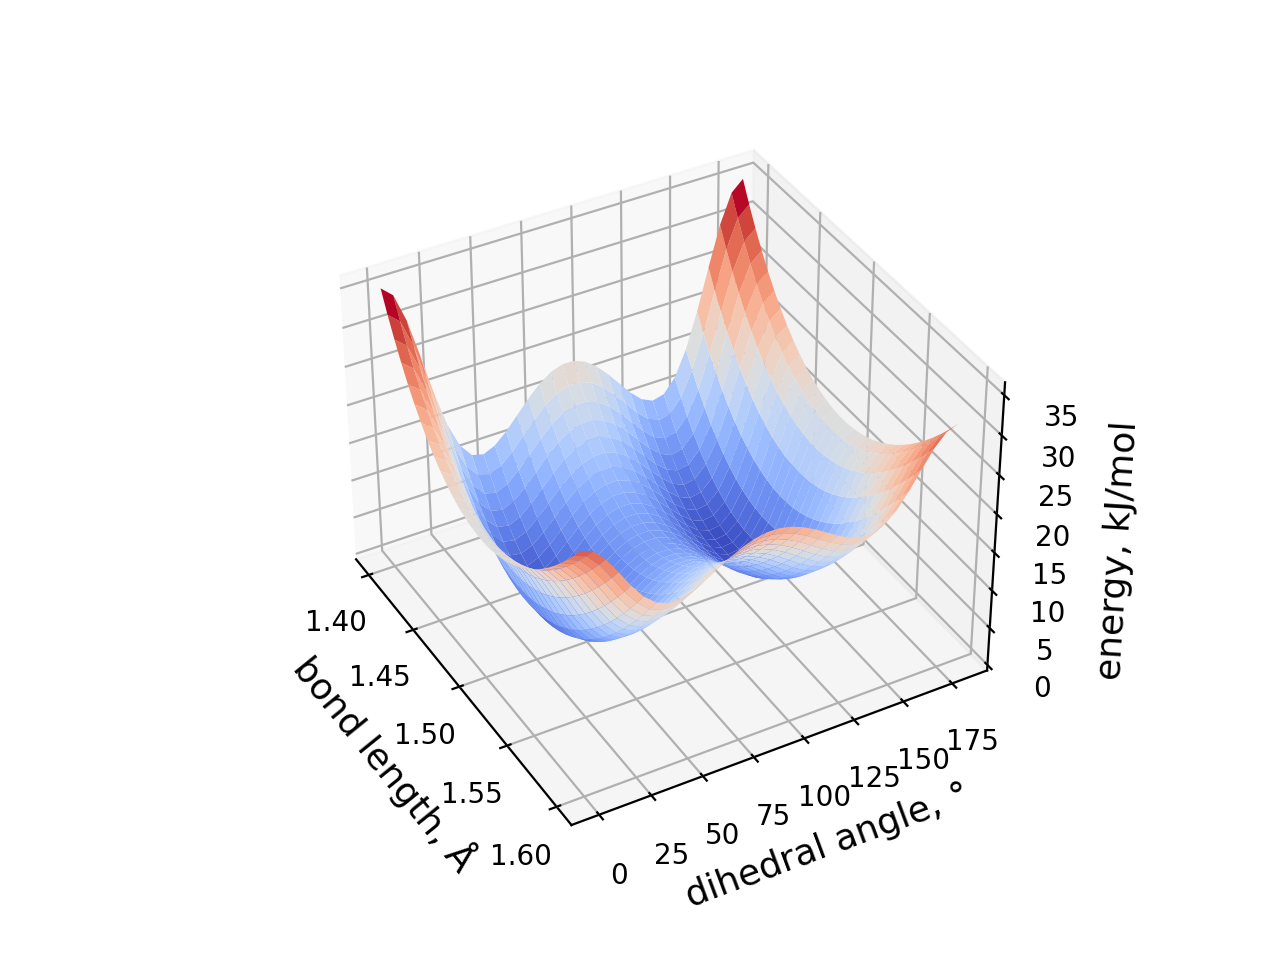

In [70]:
%matplotlib notebook
ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_surface(X, Y, 2625.5 * (energies - np.min(energies)), cmap=cm.coolwarm)
ax.set_xlabel('bond length, Å', fontsize=13)
ax.set_ylabel('dihedral angle, °', fontsize=13)
ax.set_zlabel('energy, kJ/mol', fontsize=13)
plt.show()